## Estimating Glacier Mass Balance with a Positive Degree Day Model

This model is developed by Ethan Pierce, 2022-2023.
Notebook additions by Irina Overeem, August 2023.

Required Python packages are summarized in the requirements.txt file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.plot
import rasterio.mask
import geopandas as gpd

ModuleNotFoundError: No module named 'rasterio'

Inputs:
1. DEM of the region of interest
2. Shapefile denoting glaciated areas of the catchment
3. Air temperature record

Parameters:
1. Lapse rate (decrease in temperature per elevation) --> may be a single value or a function of region, temperature, season, etc.
2. Reference height for temperature measurements --> assume sea level, but may be higher?
3. Percolation layer thickness $H_p$ --> depends on the effective porosity, is likely to be spatially variable, probably ranges from 2 to 50 m.
4. Material constant $\frac{k}{h}$ --> related to the degree-day-factor, given in units of W m$^{-2}$ $^\circ$C$^{-1}$.

## Step 1) Process input data

In [2]:
# User-specified parameters
dem_file = './inputs/dems/Pangnirtung_epsg3995.tif'
glaciers_file = './inputs/glaciers/Pangnirtung_glaciers_epsg3995.geojson'
temperature_file = './inputs/temperatures/Pang_temps_csv.csv'

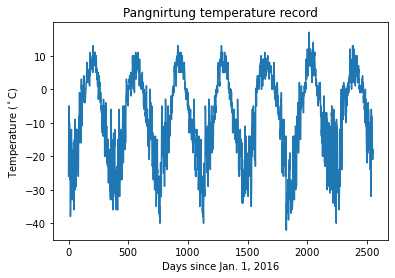

In [3]:
temp_file = np.loadtxt(temperature_file, dtype = 'int', skiprows = 8, delimiter = ',')
plt.plot(temp_file[:,1])
plt.xlabel('Days since Jan. 1, 2016')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('Pangnirtung temperature record')
plt.show()

In [4]:
dem = rio.open(dem_file)
glaciers = gpd.read_file(glaciers_file)

In [5]:
number_of_cells = len(dem.read(1)[np.where(dem.read(1) > 0)])
total_area = np.round(number_of_cells * dem.res[0] * dem.res[1] * 1e-6)
print('Total area: ' + str(total_area) + ' km^2.')

glacier_area = np.round(np.sum(glaciers.to_crs('epsg:3995').area) * 1e-6)
print('Glaciated area: ' + str(glacier_area) + ' km^2.')

print(str(np.round(glacier_area / total_area * 100)) + '% of the catchment is glaciated.')

Total area: 461.0 km^2.
Glaciated area: 194.0 km^2.
42.0% of the catchment is glaciated.


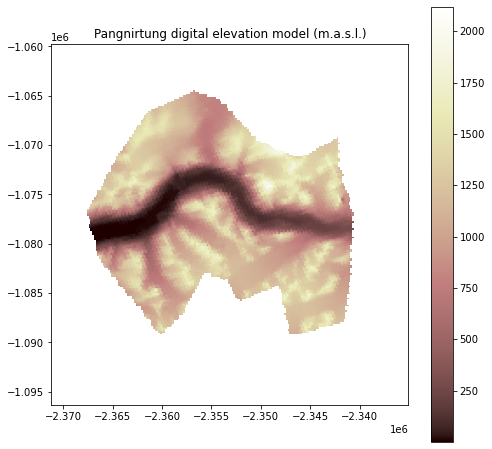

In [6]:
fig, ax = plt.subplots(figsize = (8, 8))
aspect = 1

dem_for_colorbar = np.where(dem.read(1) > 0, dem.read(1), np.nan)
hidden = ax.imshow(dem_for_colorbar, cmap = 'pink')

ele = rasterio.plot.show(dem, ax = ax, aspect = aspect, cmap = 'pink')

plt.title('Pangnirtung digital elevation model (m.a.s.l.)')
plt.colorbar(hidden)
plt.show()

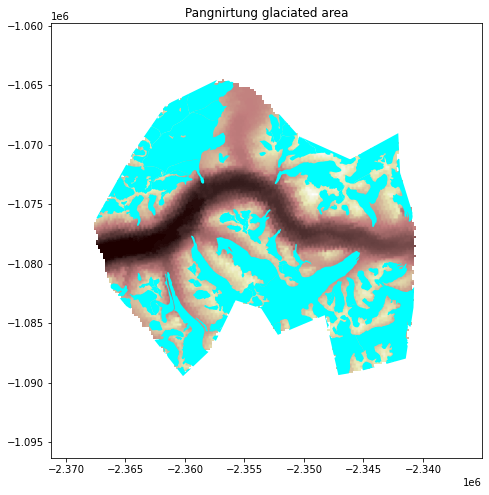

In [7]:
fig, ax = plt.subplots(figsize = (8, 8))
aspect = 1

gla = glaciers.plot(ax = ax, color = 'cyan', aspect = aspect)
ele = rasterio.plot.show(dem, ax = ax, aspect = aspect, cmap = 'pink')

plt.title('Pangnirtung glaciated area in light blue')
plt.show()

In [46]:
glacier_elevations, __ = rasterio.mask.mask(dem, glaciers.geometry)
glacier_elevations = np.where(glacier_elevations[0] > 0, glacier_elevations[0], np.nan)

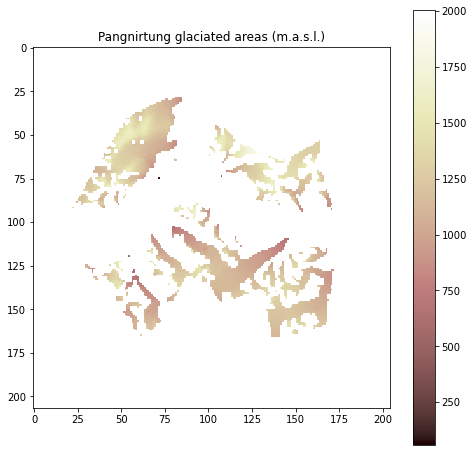

In [49]:
fig, ax = plt.subplots(figsize = (8, 8))
aspect = 1

ele = plt.imshow(glacier_elevations, aspect = aspect, cmap = 'pink')

plt.title('Pangnirtung glaciated areas (m.a.s.l.)')
plt.colorbar(ele)
plt.show()

## Step 2) Correct temperature for lapse rate

See Gardner et al. (2009) for measured lapse rates over Arctic Glaciers. Key points: many glaciers have lapse rates below the standard moist adiabatic lapse rate, and there is strong covariance in lapse rates within a given region. For initial analyses, we can use 5 degrees C / km as a representative lapse rate (from Devon Island, see ref. above). 

In [315]:
β = 5 * 1e-3

def lapse(T, z, z0, β):
    '''Given a temperature (T), elevation (z), reference elevation (z0), and lapse rate (β), compute the correct temperature at altitude.'''
    return T - β * (z - z0)

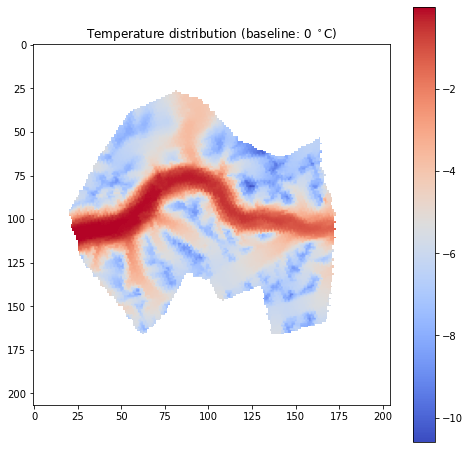

In [316]:
initial_temp = 0
z0 = 0

fig, ax = plt.subplots(figsize = (8, 8))
aspect = 1

data = np.where(dem.read(1) > 0, dem.read(1), np.nan)

temps = lapse(initial_temp, data, z0, β)

hidden = ax.imshow(temps, cmap = 'coolwarm')
Ts = ax.imshow(temps, aspect = aspect, cmap = 'coolwarm')

plt.title('Temperature distribution (baseline: 0 $^\circ$C)')
plt.colorbar(hidden)
plt.show()

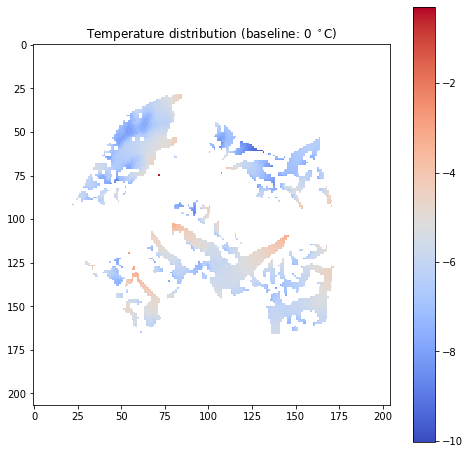

In [317]:
initial_temp = 0

fig, ax = plt.subplots(figsize = (8, 8))
aspect = 1

temps = lapse(initial_temp, glacier_elevations, z0, β)

hidden = ax.imshow(temps, cmap = 'coolwarm')
Ts = ax.imshow(temps, aspect = aspect, cmap = 'coolwarm')

plt.title('Temperature distribution (baseline: 0 $^\circ$C)')
plt.colorbar(hidden)
plt.show()

### Step 3) Utility functions: catchment melt area

Let's create a utility function to calculate the percentage of the glaciated area within the catchment that's above zero.

In [237]:
def calc_melt_area(z, T):
    '''Utility function to calculate the ratio of glaciated area above zero degrees Celsius.'''
    
    number_of_cells = np.sum(~np.isnan(z))
    cells_above_zero = np.sum(T >= 0)
    
    return cells_above_zero / number_of_cells

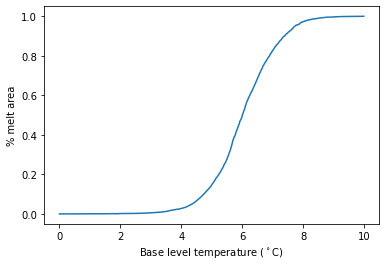

In [346]:
zs = glacier_elevations[:]
temps = np.arange(0, 10, 0.01)
ratios = []
z0 = 0

for T in temps:
    Ts = lapse(T, glacier_elevations, z0, β)
    ratios.append(calc_melt_area(zs, Ts))
    
plt.plot(temps, ratios)
plt.xlabel('Base level temperature ($^\circ$C)')
plt.ylabel('% melt area')
plt.show()

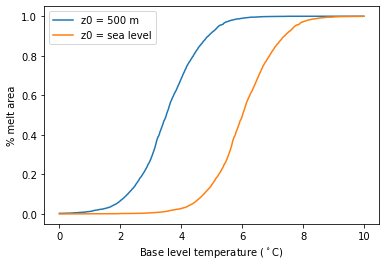

In [347]:
# Show that if you increase z0, 
old_ratios = ratios.copy()

zs = glacier_elevations[:]
temps = np.arange(0, 10, 0.01)
ratios = []
z0 = 500

for T in temps:
    Ts = lapse(T, glacier_elevations, z0, β)
    ratios.append(calc_melt_area(zs, Ts))
    
plt.plot(temps, ratios, label = 'z0 = 500 m')
plt.plot(temps, old_ratios, label = 'z0 = sea level')
plt.legend(loc = 'upper left')
plt.xlabel('Base level temperature ($^\circ$C)')
plt.ylabel('% melt area')
plt.show()

### Step 4) Physics-based surface melt model

Tsai and Ruan (2018) update the canonical positive-degree-day model to account for delays in melt related to warming ice from temperatures well below the melting point. Here, we apply equations (4) and (5) from their paper, first solving a 1D, linear ODE for the temperature of the percolation zone, and second solving an algebraic equation for the resulting ablation at the surface. The temperature of the percolation zone, $T_p$, is given by:

$$
\frac{d T_p}{d t} = \frac{k}{h\rho c H_p}(T_a - T_p),
$$
when the air temperature $T_a < 0$ or percolation temperature $T_p < 0$, with a thermal conductivity of air $k$, measurement height $h$, ice density $\rho$, heat capacity $c$, and percolation zone thickness $H_p$ all assumed to be known constants. When $T_a > 0$ and $T_p = 0$, the ablation rate is given by:

$$
a(t) = \frac{k}{h \rho L}T_a,
$$
where $L$ is the latent heat of ice, and $a(t)$ can be integrated over a day to calculate total ablation. For ease of notation, let $K\equiv\frac{k}{h}$.

In [334]:
K = 24
Hp = 2
ρ = 917
c = 2100
L = 3.34e5

def calc_melt_rate(t, T0, Ta):
    '''Calculate the ablation rate over a time step, given an initial temperature and a current air temperature.'''
    
    dT = K / (ρ * c * Hp) * (Ta - T0)
    new_T = np.where(T0 + dT * t <= 0, T0 + dT * t, 0)
    new_T = np.where(~np.isnan(z), new_T, np.nan)
    
    ablation_rate = np.where((new_T == 0) & (Ta > 0), K / (ρ * L) * Ta, 0.0)
    ablation = ablation_rate * t
        
    return new_T, ablation

### Step 5) Run the model for the range of temperatures given

Each time step, we want to: (1) update the temperatures and melt rate, (2) calculate the percentage of glaciated area that's subject to melting, and (3) integrate the total melt over the catchment.

In [343]:
melt_area = []
melt_total = []

days = temp_file[:, 0]
temperatures = temp_file[:, 1]
z = glacier_elevations
z0 = 250

initial_T = -26
T = lapse(initial_T, z, z0, β)
seconds_per_day = 60 * 60 * 24

for idx in range(len(days)):
    
    air_temperatures = lapse(temperatures[idx], z, z0, β)
    T, A = calc_melt_rate(seconds_per_day, T, air_temperatures)
    
    melt_area.append(calc_melt_area(z, T))
    melt_total.append(np.sum(A * dem.res[0] * dem.res[1]))
    

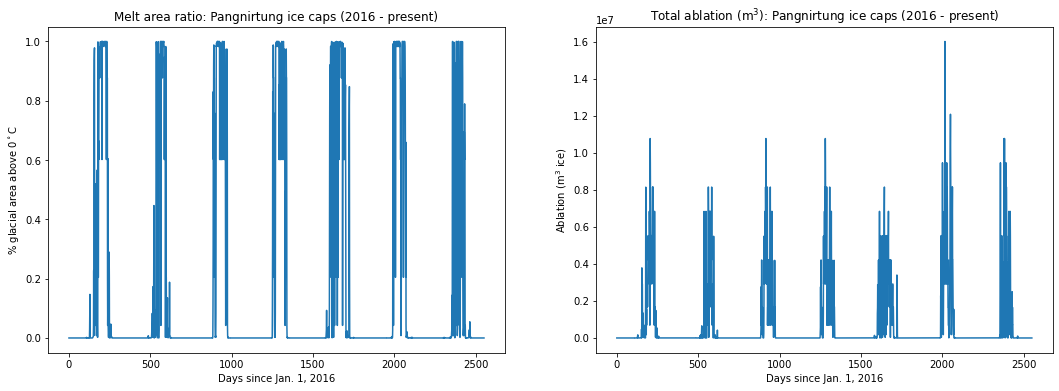

In [365]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))

ax[0].set_title('Melt area ratio: Pangnirtung ice caps (2016 - present)')
ax[0].set_xlabel('Days since Jan. 1, 2016')
ax[0].set_ylabel('% glacial area above 0$^\circ$C')
ax[0].plot(melt_area)

ax[1].set_title('Total ablation (m$^3$): Pangnirtung ice caps (2016 - present)')
ax[1].set_xlabel('Days since Jan. 1, 2016')
ax[1].set_ylabel('Ablation (m$^3$ ice)')
ax[1].plot(melt_total)

plt.show()

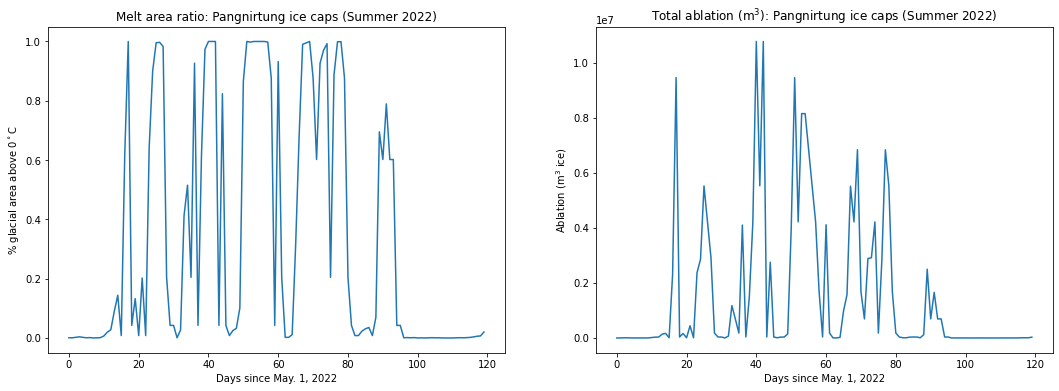

In [369]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))

ax[0].set_title('Melt area ratio: Pangnirtung ice caps (Summer 2022)')
ax[0].set_xlabel('Days since May. 1, 2022')
ax[0].set_ylabel('% glacial area above 0$^\circ$C')
ax[0].plot(melt_area[int(365*6 + 150):int(365*6 + 270)])
# ax[0].plot(temperatures[int(365*6 + 150):int(365*6 + 270)] / np.max(temperatures[int(365*6 + 150):int(365*6 + 270)]), linestyle = '--')

ax[1].set_title('Total ablation (m$^3$): Pangnirtung ice caps (Summer 2022)')
ax[1].set_xlabel('Days since May. 1, 2022')
ax[1].set_ylabel('Ablation (m$^3$ ice)')
ax[1].plot(melt_total[int(365*6 + 150):int(365*6 + 270)])
# ax[1].plot(melt_total[int(365*6 + 150):int(365*6 + 270)] / np.max(melt_total[int(365*6 + 150):int(365*6 + 270)]))
# ax[1].plot(temperatures[int(365*6 + 150):int(365*6 + 270)] / np.max(temperatures[int(365*6 + 150):int(365*6 + 270)]), linestyle = '--')

plt.show()

### References

Tsai, V. and Ruan, X. A simple physics-based improvement to the positive degree day model. JGLAC, 64(246), 661-668. DOI: https://doi.org/10.1017/jog.2018.55

Gardner et al. (2009). Near-Surface Temperature Lapse Rates over Arctic Glaciers and Their Implications for Temperature Downscaling.https://doi.org/10.1175/2009JCLI2845.1

